In [11]:
# Import the required packages

# Figures
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

# Ipython notebook basics
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.setrecursionlimit(5000)

# Things I use everytime
import numpy as np
np.random.seed(42)
import pandas as pd
#import scipy.stats as stats

import statsmodels.api as sm
import re
import seaborn as sns

import scipy.stats as stats

In [3]:
# Parameter tagged cell for papermill
filename = "default"
#iso_seq_gene = pd.read_csv(f"/mmfs1/gscratch/stergachislab/yhhc/projects/Iso-seq_public/Cyclo_noncyclo_comparison/Analysis/6.10.24/3.Compare_samples/3.Novel_iso_abundance_in_gene/data_combined_full_gene_with_Hyp5.csv",sep=",")
#iso_seq_gene = pd.read_csv(f"/mmfs1/gscratch/stergachislab/yhhc/projects/Iso-seq_public/Cyclo_noncyclo_comparison/Analysis/6.10.24/3.Compare_samples/1.Isoform/data_combined_full.csv",sep=",")


/tmp/ipykernel_50668/2810058351.py:2: DtypeWarning: Columns (37,38,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  iso_seq_gene = pd.read_csv(f"/mmfs1/gscratch/stergachislab/yhhc/projects/Iso-seq_public/Cyclo_noncyclo_comparison/Analysis/6.10.24/3.Compare_samples/1.Isoform/data_combined_full.csv",sep=",")


In [ ]:
iso_seq_gene = pd.read_csv(filename,sep=",")

In [4]:
# Remove isoforms with low counts in all patients.

# Define count threshold
count_threshold = 10

# Group by 'Isoform_PBid' and check if any counts meet the threshold
isoforms_to_keep = iso_seq_gene.groupby('Isoform_PBid').apply(
    lambda group: any(group['cyclo_count'] >= count_threshold) or any(group['noncyclo_count'] >= count_threshold)
)

# Filter to keep only isoforms that meet the threshold
isoforms_to_keep = isoforms_to_keep[isoforms_to_keep].index.tolist()

# Print helpful statements
print("Number of isoforms to keep after filtering based on counts:")
print(len(isoforms_to_keep))

# Filter the data_with_totals to keep only the desired Isoform_PBid
iso_seq_gene = iso_seq_gene[iso_seq_gene['Isoform_PBid'].isin(isoforms_to_keep)]


/tmp/ipykernel_50668/2184626134.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  isoforms_to_keep = iso_seq_gene.groupby('Isoform_PBid').apply(


Number of isoforms to keep after filtering based on counts:
186466


In [5]:
# In the iso_seq_gene pd dataframe, I have a column called Cyclo_TPM and another column called Noncyclo_TPM.
# I want to create a column called test_statistic that is calculated by doing this:
# ratio = (Cyclo_TPM+1)/(Noncyclo_TPM+1)
# absolute_diff = abs(Cyclo_TPM - Noncyclo_TPM)
# test_statistic = log2(ratio) * log2(5*absolute_diff)

df = iso_seq_gene

# Calculate the adjusted ratio
df['ratio'] = (df['Cyclo_TPM'] + 1) / (df['Noncyclo_TPM'] + 1)

# Calculate the absolute difference
df['absolute_diff'] = abs(df['Cyclo_TPM'] - df['Noncyclo_TPM'])

# Calculate the test statistic
# df['test_statistic'] = np.log2(df['ratio']) * np.log2((5 * df['absolute_diff']) + 1)
df['test_statistic'] = np.log2(df['ratio']) * np.log2((df['cyclo_count']) + 2)


# Handle cases where absolute_diff is zero to avoid log2(0) errors
#df['test_statistic'] = df.apply(lambda row: np.nan if row['absolute_diff'] == 0 else row['test_statistic'], axis=1)


In [6]:
# Calculate z-score, compares patient to other patients.

# Function to calculate the z-score for each row within a group
def calculate_z_score_within_group(group):
    group = group.copy()  # Avoid SettingWithCopyWarning
    for i, row in group.iterrows():
        other_test_statistics = group.loc[group.index != i, 'test_statistic']
        median_others = other_test_statistics.median()
        sd_all = group['test_statistic'].std()

        if sd_all == 0:
            group['z_score'] = 0
        else:
            group.at[i, 'z_score'] = (row['test_statistic'] - median_others) / sd_all
            # Can't use IQR because iqr is 0 for the HARS1 positive control case and causes division by zero. 
    
    return group


# from scipy.stats import iqr
# def calculate_z_score_within_group(group):
#     group = group.copy()  # Avoid SettingWithCopyWarning
#     for i, row in group.iterrows():
#         other_test_statistics = group.loc[group.index != i, 'test_statistic']
#         median_others = other_test_statistics.median()
#         iqr_all = iqr(group['test_statistic'])

#         if iqr_all == 0:
#             group['z_score'] = 0
#         else:
#             group.at[i, 'z_score'] = (row['test_statistic'] - median_others) / iqr_all
    
#     return group

# Apply the function to each group
df = df.groupby('Isoform_PBid').apply(calculate_z_score_within_group)

# Reset index to clean up the DataFrame
df.reset_index(drop=True, inplace=True)


#[T1 - mean(T2,...,T18)]/SD(T1,....,T18)

/tmp/ipykernel_50668/4043802266.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Isoform_PBid').apply(calculate_z_score_within_group)


## Histogram of test statistic

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        3.000000e+00, 2.000000e+00, 2.000000e+00, 3.000000e+00,
        2.000000e+00, 7.000000e+00, 8.000000e+00, 1.100000e+01,
        1.300000e+01, 3.000000e+01, 3.300000e+01, 4.100000e+01,
        6.500000e+01, 1.100000e+02, 1.770000e+02, 2.870000e+02,
        4.470000e+02, 8.630000e+02, 1.610000e+03, 3.186000e+03,
        6.746000e+03, 1.595400e+04, 4.272100e+04, 1.632560e+05,
        2.877431e+06, 1.558990e+05, 4.059900e+04, 1.751800e+04,
        9.516000e+03, 5.448000e+03, 3.582000e+03, 2.499000e+03,
        1.748000e+03, 1.312000e+03, 9.860000e+02, 7.560000e+02,
        5.980000e+02, 4.710000e+02, 4.020000e+02, 3.150000e+02,
        2.290000e+02, 2.000000e+02, 1.690000e+02, 1.300000e+02,
        1.260000e+02, 1.270000e+02, 8.700000e+01, 8.100000e+01,
        6.100000e+01, 5.300000e+01, 5.30

Text(0.5, 0, 'Test Statistic')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Test Statistic Values')

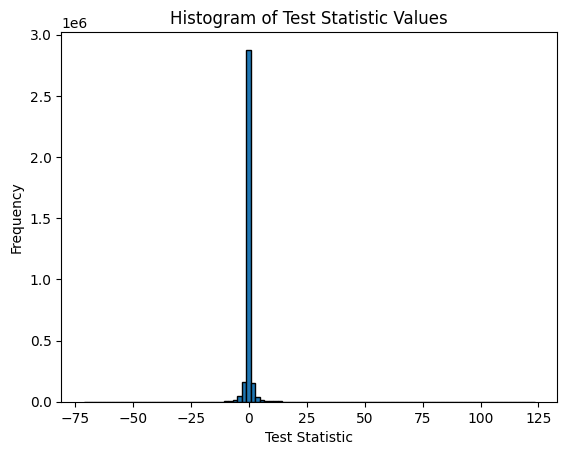

In [8]:
# Drop NaN values from the test_statistic column for plotting
test_statistic_values = df['test_statistic'].dropna()

# Create a histogram of the test_statistic values
plt.hist(test_statistic_values, bins=100, edgecolor='black')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Histogram of Test Statistic Values')
plt.show()

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        3.000000e+00, 2.000000e+00, 2.000000e+00, 3.000000e+00,
        2.000000e+00, 7.000000e+00, 8.000000e+00, 1.100000e+01,
        1.300000e+01, 3.000000e+01, 3.300000e+01, 4.100000e+01,
        6.500000e+01, 1.100000e+02, 1.770000e+02, 2.870000e+02,
        4.470000e+02, 8.630000e+02, 1.610000e+03, 3.186000e+03,
        6.746000e+03, 1.595400e+04, 4.272100e+04, 1.632560e+05,
        2.877431e+06, 1.558990e+05, 4.059900e+04, 1.751800e+04,
        9.516000e+03, 5.448000e+03, 3.582000e+03, 2.499000e+03,
        1.748000e+03, 1.312000e+03, 9.860000e+02, 7.560000e+02,
        5.980000e+02, 4.710000e+02, 4.020000e+02, 3.150000e+02,
        2.290000e+02, 2.000000e+02, 1.690000e+02, 1.300000e+02,
        1.260000e+02, 1.270000e+02, 8.700000e+01, 8.100000e+01,
        6.100000e+01, 5.300000e+01, 5.30

Text(0.5, 0, 'Test Statistic')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Zoomed in Histogram of Test Statistic Values')

(-3.0, 3.0)

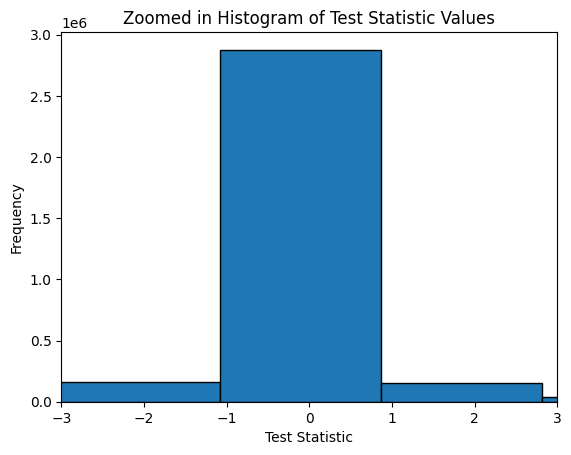

In [9]:
plt.hist(test_statistic_values, bins=100, edgecolor='black')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Zoomed in Histogram of Test Statistic Values')
plt.xlim(-3, 3)  # Set x-axis range from -25 to 25
plt.show()

## Summary stats of test statistic

In [10]:
# Drop NaN values from the test_statistic column
test_statistic_values = df['test_statistic'].dropna() # NA occurs when the abs diff is 0 and you take log2(0)

# Get summary statistics
summary_stats = test_statistic_values.describe()
summary_stats

count    3.356388e+06
mean     3.905429e-02
std      2.006081e+00
min     -7.108434e+01
25%     -8.717353e-02
50%      0.000000e+00
75%      4.115886e-02
max      1.233832e+02
Name: test_statistic, dtype: float64

In [11]:
# The amount of NAs should equal the amount of rows with abs diff of 0.
num_na_values = df['test_statistic'].isna().sum()

# Count the number of rows where absolute_diff is zero
num_abs_diff_zero = (df['absolute_diff'] == 0).sum()

print("\nNumber of NaN values in test_statistic:", num_na_values)
print("Number of rows with absolute_diff equal to 0:", num_abs_diff_zero)


Number of NaN values in test_statistic: 0
Number of rows with absolute_diff equal to 0: 947670


In [12]:
# Get the row with the max test_statistic
max_test_statistic_row = df.loc[df['test_statistic'].idxmax()]

# Get the row with the min test_statistic
min_test_statistic_row = df.loc[df['test_statistic'].idxmin()]

max_min_test_statistic_df = pd.DataFrame([max_test_statistic_row, min_test_statistic_row])

# Set display options to show all columns
pd.set_option('display.max_columns', None)

max_min_test_statistic_df

# Reset to default after displaying
pd.reset_option('display.max_columns')

,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,Max_P_Value_Hyp2_above_median,Max_P_Value_Hyp3_below_median,Max_P_Value_Hyp3_above_median,cyclo_total_sum,noncyclo_total_sum,CycloFraction,NoncycloFraction,Cyclo_TPM,Noncyclo_TPM,NormalizedCycloFraction,NormalizedNoncycloFraction,NormalizedFractionDifference,Avg_Cyclo_TPM,Avg_Noncyclo_TPM,gene_cyclo_total,gene_noncyclo_total,isoform_cyclo_proportion,isoform_noncyclo_proportion,SD_Cyclo_TPM,SD_Noncyclo_TPM,Cyclo_Z_Score,Noncyclo_Z_Score,MedianCyclo_TPM,MedianNoncyclo_TPM,Cyclo_TPM_Rank,Noncyclo_TPM_Rank,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,ratio,absolute_diff,test_statistic,z_score
1805639,PB.19026.229,BCH_1199-01,42299,27,full-splice_match,EGR4,ENST00000436467.4,alternative_3end,0.0,NaN,8.000920e-01,NaN,0.0,6681027,4322823,0.006331,0.000006,6331.212252,6.245918,0.999014,0.000986,0.998029,1525.143970,3.273745,93797,75,0.450963,0.360000,1356.221683,3.120737,3.543719,0.952395,1118.736987,2.538054,18.0,15.0,chr2,73290929.0,73293548.0,2p13,2p13.2,128992.0,"""EGR4, NGFIC""",Early growth response-4,1961.0,ENSG00000135625,NaN,NaN,Egr4 (MGI:99252),False,873.900567,6324.966334,123.383210,2.106096
89459,PB.105358.48,UDN687128,174,15120,full-splice_match,ACTA2,ENST00000224784.10,reference_match,0.0,NaN,3.525674e-10,0.000551,NaN,6511898,6575584,0.000027,0.002299,26.720320,2299.415535,0.011487,0.988513,-0.977026,1127.293188,1778.363618,246,16021,0.707317,0.943761,1357.282498,2215.019727,-0.810865,0.235236,621.304134,327.822896,3.0,13.0,chr10,88935074,88991337,10q22-q24,10q23.31,102620,"""ACTA2, ACTSA, AAT6, MYMY5, SMDYS""","""Actin, alpha-2, smooth muscle, aorta""",59,ENSG00000107796,NaN,"""Smooth muscle dysfunction syndrome, 613834 (3...",Acta2 (MGI:87909),True,0.012050,2272.695215,-71.084343,-3.790521


## Histogram of z-scores

(array([  6522.,   3248.,   3265.,   3338.,   3556.,   3604.,   3815.,
          3917.,   3902.,   4174.,   4419.,   4567.,   4545.,   4806.,
          5101.,   5329.,   5615.,   5878.,   6101.,   6386.,   6802.,
          7114.,   7645.,   8096.,   8600.,   9088.,   9809.,  10256.,
         11185.,  11927.,  13010.,  14285.,  15683.,  17031.,  19261.,
         21554.,  25105.,  28958.,  34292.,  41122.,  49206.,  60589.,
         74608.,  90312., 109655., 129916., 152272., 159865., 127260.,
        132747., 142892., 161823., 236323., 238947., 217743., 167850.,
        121931.,  89453.,  68224.,  52686.,  42026.,  33840.,  28612.,
         23644.,  20555.,  18114.,  16066.,  14088.,  12977.,  11667.,
         10503.,   9735.,   8729.,   8090.,   7413.,   7001.,   6436.,
          5922.,   5609.,   5148.,   4785.,   4438.,   4214.,   3868.,
          3731.,   3517.,   3329.,   3132.,   2879.,   2730.,   2657.,
          2590.,   2388.,   2352.,   2254.,   2157.,   2179.,   2124.,
      

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values')

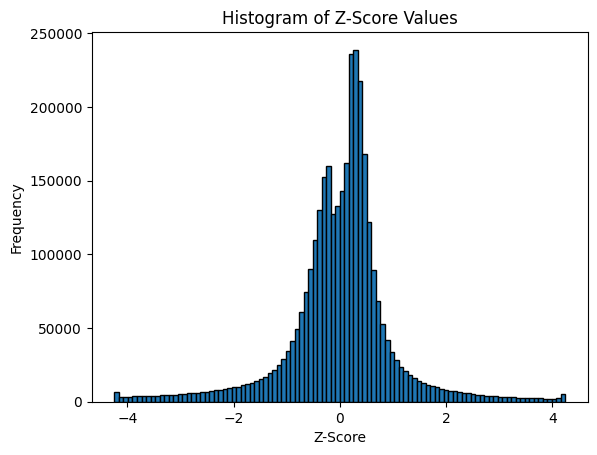

In [14]:
# Drop NaN values from the test_statistic column for plotting
z_score_values = df['z_score'].dropna()

# Create a histogram of the test_statistic values
plt.hist(z_score_values, bins=100, edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Histogram of Z-Score Values')
plt.show()

## Summary stats of z-scores

In [15]:
# Drop NaN values from the test_statistic column
z_score_values = df['z_score'].dropna() # NA occurs when the abs diff is 0 and you take log2(0)

# Get summary statistics
summary_stats_z_score = z_score_values.describe()
summary_stats_z_score

count    3.356388e+06
mean     1.907934e-19
std      1.028992e+00
min     -4.242641e+00
25%     -3.951333e-01
50%      1.048765e-01
75%      4.334191e-01
max      4.242641e+00
Name: z_score, dtype: float64

In [16]:
# The amount of NAs should equal the amount of rows with abs diff of 0. LEFT OFF HERE
num_na_values = df['z_score'].isna().sum()

# Count the number of rows where absolute_diff is zero
num_abs_diff_zero = (df['absolute_diff'] == 0).sum()

print("\nNumber of NaN values in z_score:", num_na_values)
print("Number of rows with absolute_diff equal to 0:", num_abs_diff_zero)


Number of NaN values in z_score: 0
Number of rows with absolute_diff equal to 0: 947670


In [17]:
# Get the row with the max test_statistic
max_z_score_row = df.loc[df['z_score'].idxmax()]

# Get the row with the min test_statistic
min_z_score_row = df.loc[df['z_score'].idxmin()]

max_min_z_score_df = pd.DataFrame([max_z_score_row, min_z_score_row])

# Set display options to show all columns
pd.set_option('display.max_columns', None)

max_min_z_score_df

# Reset to default after displaying
pd.reset_option('display.max_columns')

,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,Max_P_Value_Hyp2_above_median,Max_P_Value_Hyp3_below_median,Max_P_Value_Hyp3_above_median,cyclo_total_sum,noncyclo_total_sum,CycloFraction,NoncycloFraction,Cyclo_TPM,Noncyclo_TPM,NormalizedCycloFraction,NormalizedNoncycloFraction,NormalizedFractionDifference,Avg_Cyclo_TPM,Avg_Noncyclo_TPM,gene_cyclo_total,gene_noncyclo_total,isoform_cyclo_proportion,isoform_noncyclo_proportion,SD_Cyclo_TPM,SD_Noncyclo_TPM,Cyclo_Z_Score,Noncyclo_Z_Score,MedianCyclo_TPM,MedianNoncyclo_TPM,Cyclo_TPM_Rank,Noncyclo_TPM_Rank,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,ratio,absolute_diff,test_statistic,z_score,neg_log_P_Value_Hyp1
325272,PB.114523.319,UDN212054,15,6,novel_not_in_catalog,SIK2,novel,at_least_one_novel_splicesite,0.091415,NaN,0.076413,NaN,0.006378,5582703,5443396,0.000003,0.000001,2.68687,1.102253,0.709101,0.290899,0.418202,0.149271,0.061236,126,71,0.119048,0.084507,0.633301,0.259804,4.006938,4.006938,0.0,0.0,18.0,18.0,chr11,111602449.0,111730855.0,11q23.1,11q23.1,608973.0,"""SIK2, KIAA0781""",Salt-inducible kinase 2,23235.0,ENSG00000170145,NaN,NaN,Sik2 (MGI:2445031),False,1.753771,1.584617,1.110291,4.242641,1.038981
79454,PB.104530.2843,BCH_2275-01,14,25,novel_not_in_catalog,ZNF503,novel,at_least_one_novel_splicesite,0.270400,NaN,0.000074,NaN,0.007039,5298875,6226665,0.000003,0.000004,2.64207,4.014990,0.396882,0.603118,-0.206235,0.146782,0.223055,180,211,0.077778,0.118483,0.622742,0.946342,4.006938,4.006938,0.0,0.0,18.0,18.0,chr10,75279725.0,75401916.0,10q22.2,10q22.2,613902.0,"""ZNF503, NOLZ1""",Zinc finger protein 503,84858.0,ENSG00000165655,NaN,NaN,Zfp503 (MGI:1353644),False,0.726237,1.372920,-0.575320,-4.242641,0.567994


## Correlation of z-score with P_Value_Hyp1

/mmfs1/gscratch/stergachislab/yhhc/tools/miniconda3/miniconda3/envs/jupyter-notebook/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'z_score')

Text(0, 0.5, '-log10(P_Value_Hyp1)')

Text(0.5, 1.0, 'Scatter Plot of Z-Score with NormalizedFractionDifference >0 vs. -log10(P_Value_Hyp1)\nCorrelation: 0.09')

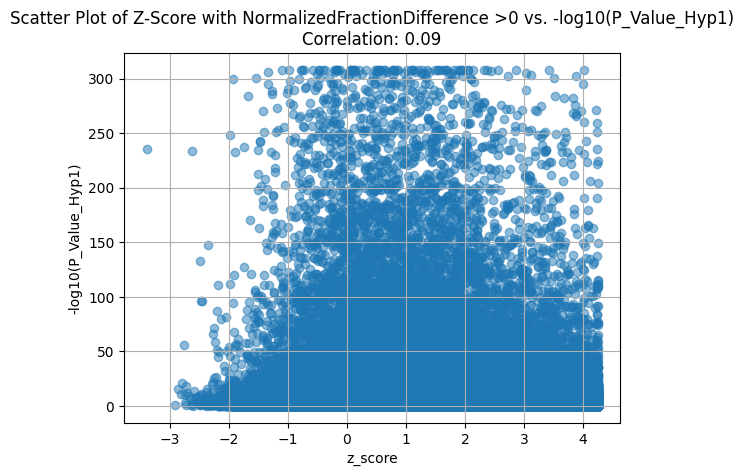

In [18]:

# # Calculate the negative log of P_Value_Hyp1
# df['neg_log_P_Value_Hyp1'] = -np.log10(df['P_Value_Hyp1'])

# # Filter the DataFrame to only include rows where NormalizedFractionDifference > 0
# filtered_df = df[df['NormalizedFractionDifference'] > 0]

# # Drop NaN values from the test_statistic and neg_log_P_Value_Hyp1 columns for correlation analysis
# filtered_df = filtered_df.dropna(subset=['z_score', 'neg_log_P_Value_Hyp1'])

# # Calculate the correlation value
# correlation_value = filtered_df[['z_score', 'neg_log_P_Value_Hyp1']].corr().loc['z_score', 'neg_log_P_Value_Hyp1']

# # Create the scatter plot
# plt.scatter(filtered_df['z_score'], filtered_df['neg_log_P_Value_Hyp1'], alpha=0.5)
# plt.xlabel('z_score')
# plt.ylabel('-log10(P_Value_Hyp1)')
# plt.title(f'Scatter Plot of Z-Score with NormalizedFractionDifference >0 vs. -log10(P_Value_Hyp1)\nCorrelation: {correlation_value:.2f}')
# plt.grid(True)
# plt.show()

## Write outputs

In [ ]:
df.to_csv('test_statistic_hyp1.csv', index=False)

In [ ]:
import pickle

# Function to save variables
def save_variables(filename, variables):
    with open(filename, 'wb') as f:
        pickle.dump(variables, f)

# Save specific variables
variables_to_save = {
    'df': df
}
save_variables('Test_statistic_hyp1_notebook_variables.pkl', variables_to_save)

# Load variables from a file
# def load_variables(filename):
#     with open(filename, 'rb') as f:
#         variables = pickle.load(f)
#     return variables

# # Load the variables
# loaded_variables = load_variables('notebook_variables.pkl')

# # Access the loaded variables
# df = loaded_variables['df']

## Positive controls

In [19]:
# LEFT OFF HERE. Display all the positive control cases.

#UDN212054 HARS1
#UDN633333 MFN2
#UDN215640 SET

# Define the pairs to match
matching_pairs = {
    'UDN212054': 'HARS1',
    'UDN633333': 'MFN2',
    'UDN215640': 'SET'
}

# Filter the DataFrame based on the matching pairs
filtered_df = df[df.apply(lambda row: matching_pairs.get(row['Sample']) == row['associated_gene'], axis=1)]

# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#data_df[data_df['associated_gene'] == 'MFN2']
filtered_df

# Reset to default after displaying
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')



,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,Max_P_Value_Hyp2_above_median,Max_P_Value_Hyp3_below_median,Max_P_Value_Hyp3_above_median,cyclo_total_sum,noncyclo_total_sum,CycloFraction,NoncycloFraction,Cyclo_TPM,Noncyclo_TPM,NormalizedCycloFraction,NormalizedNoncycloFraction,NormalizedFractionDifference,Avg_Cyclo_TPM,Avg_Noncyclo_TPM,gene_cyclo_total,gene_noncyclo_total,isoform_cyclo_proportion,isoform_noncyclo_proportion,SD_Cyclo_TPM,SD_Noncyclo_TPM,Cyclo_Z_Score,Noncyclo_Z_Score,MedianCyclo_TPM,MedianNoncyclo_TPM,Cyclo_TPM_Rank,Noncyclo_TPM_Rank,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,ratio,absolute_diff,test_statistic,z_score,neg_log_P_Value_Hyp1
2564544,PB.60131.268,UDN212054,69,69,full-splice_match,HARS1,ENST00000504156.7,alternative_3end,9.495298e-01,1.248468e-27,NaN,7.110173e-39,NaN,5582703,5443396,1.235960e-05,1.267591e-05,12.359604,12.675910,0.493683,0.506317,-0.012634,79.036021,95.673255,160,85,0.431250,0.811765,23.092405,30.740676,-2.887374,-2.699919,78.261022,94.110967,1.0,1.0,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,0.976871,0.316306,-1.338551e-02,0.791427,2.249142e-02
2564562,PB.60131.271,UDN212054,0,0,full-splice_match,HARS1,ENST00000504156.7,alternative_3end5end,NaN,NaN,NaN,NaN,NaN,5582703,5443396,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.172083,0.324832,160,85,0.000000,0.000000,0.272517,0.497972,-0.631457,-0.652310,0.000000,0.062150,6.0,5.0,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,1.000000,0.000000,0.000000e+00,0.353203,NaN
2564580,PB.60131.272,UDN212054,1,1,full-splice_match,HARS1,ENST00000438307.6,alternative_3end,1.000000e+00,1.433702e-01,NaN,7.408294e-01,NaN,5582703,5443396,1.791247e-07,1.837088e-07,0.179125,0.183709,0.493683,0.506317,-0.012634,1.561667,1.923229,160,85,0.006250,0.011765,0.848478,1.008062,-1.629438,-1.725608,1.365318,1.604220,1.0,1.0,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,0.996127,0.004584,-3.693771e-05,0.385820,5.472558e-14
2564598,PB.60131.273,UDN212054,0,0,incomplete-splice_match,HARS1,ENST00000504366.5,3prime_fragment,NaN,NaN,NaN,NaN,NaN,5582703,5443396,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.391329,0.408552,160,85,0.000000,0.000000,0.289952,0.389146,-1.349634,-1.049870,0.381769,0.418611,2.5,3.5,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,1.000000,0.000000,0.000000e+00,-0.095360,NaN
2564616,PB.60131.274,UDN212054,0,1,incomplete-splice_match,HARS1,ENST00000675898.1,3prime_fragment,9.899188e-01,NaN,1.000000e+00,NaN,NaN,5582703,5443396,0.000000e+00,1.837088e-07,0.000000,0.183709,0.000000,1.000000,-1.000000,0.251560,0.347369,160,85,0.000000,0.011765,0.364461,0.483495,-0.690224,-0.338494,0.062629,0.137070,5.0,11.0,chr5,140673905.0,140691370.0,5q31.3,5q31.3,142810.0,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035.0,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,0.844802,0.183709,-5.920183e-02,-0.014970,4.400416e-03
2564634,PB.60131.275,UDN212054,0,0,incomplete-splice_match,HARS1,ENST00000675898.1,3prime

## SRSF6 cassette exon positive control

In [20]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

df[df['associated_gene'] == 'SRSF6']

# Reset to default after displaying
pd.reset_option('display.max_columns')


,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,Max_P_Value_Hyp2_above_median,Max_P_Value_Hyp3_below_median,Max_P_Value_Hyp3_above_median,cyclo_total_sum,noncyclo_total_sum,CycloFraction,NoncycloFraction,Cyclo_TPM,Noncyclo_TPM,NormalizedCycloFraction,NormalizedNoncycloFraction,NormalizedFractionDifference,Avg_Cyclo_TPM,Avg_Noncyclo_TPM,gene_cyclo_total,gene_noncyclo_total,isoform_cyclo_proportion,isoform_noncyclo_proportion,SD_Cyclo_TPM,SD_Noncyclo_TPM,Cyclo_Z_Score,Noncyclo_Z_Score,MedianCyclo_TPM,MedianNoncyclo_TPM,Cyclo_TPM_Rank,Noncyclo_TPM_Rank,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,ratio,absolute_diff,test_statistic,z_score,neg_log_P_Value_Hyp1
1494972,PB.164087.115,BCH_1877-01,11,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,0.002781,NaN,NaN,NaN,1.000000,8514101,8390417,1.291974e-06,0.000000e+00,1.291974,0.000000,1.000000,0.000000,1.000000,0.285913,0.02281,1297,685,0.008481,0.000000,0.457893,0.062997,2.197154,-0.362082,0.000000,0.0,17.0,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,2.291974,1.291974,1.431830,2.917943,2.555747
1494973,PB.164087.115,BCH_2410-01,0,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,NaN,NaN,NaN,NaN,NaN,5115261,5604045,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.285913,0.02281,106,96,0.000000,0.000000,0.457893,0.062997,-0.624411,-0.362082,0.000000,0.0,5.5,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,1.000000,0.000000,0.000000,-0.573589,NaN
1494974,PB.164087.115,BCH_2275-01,2,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,0.410155,NaN,NaN,NaN,1.000000,5298875,6226665,3.774386e-07,0.000000e+00,0.377439,0.000000,1.000000,0.000000,1.000000,0.285913,0.02281,417,307,0.004796,0.000000,0.457893,0.062997,0.199884,-0.362082,0.000000,0.0,14.0,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,1.377439,0.377439,0.213433,-0.053130,0.387052
1494975,PB.164087.115,BCH_2443-01,0,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,NaN,NaN,NaN,NaN,NaN,7983565,8045116,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,0.285913,0.02281,60,40,0.000000,0.000000,0.457893,0.062997,-0.624411,-0.362082,0.000000,0.0,5.5,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,1.000000,0.000000,0.000000,-0.573589,NaN
1494976,PB.164087.115,BCH_0252-01,2,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,0.671662,NaN,NaN,NaN,1.000000,6655551,4374934,3.005010e-07,0.000000e+00,0.300501,0.000000,1.000000,0.000000,1.000000,0.285913,0.02281,402,308,0.004975,0.000000,0.457893,0.062997,0.031858,-0.362082,0.000000,0.0,13.0,8.0,chr20,43457896.0,43464243.0,20q13.11,20q13.11,601944.0,"""SRSF6, SFRS6, SRp55""","""Splicing factor, serine/arginine-rich, 6""",6431.0,ENSG00000124193,NaN,NaN,Srsf6 (MGI:1915246),False,1.300501,0.300501,0.143692,-0.223194,0.172849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495435,PB.164087.72,UDN215640,5,0,novel_not_in_catalog,SRSF6,novel,at_least_one_novel_splicesite,0.060249,Na

## HARS1 UDN212054 positive control

In [21]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

df[df['Isoform_PBid'] == 'PB.60131.293']

# Reset to default after displaying
pd.reset_option('display.max_columns')

,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,Max_P_Value_Hyp2_above_median,Max_P_Value_Hyp3_below_median,Max_P_Value_Hyp3_above_median,cyclo_total_sum,noncyclo_total_sum,CycloFraction,NoncycloFraction,Cyclo_TPM,Noncyclo_TPM,NormalizedCycloFraction,NormalizedNoncycloFraction,NormalizedFractionDifference,Avg_Cyclo_TPM,Avg_Noncyclo_TPM,gene_cyclo_total,gene_noncyclo_total,isoform_cyclo_proportion,isoform_noncyclo_proportion,SD_Cyclo_TPM,SD_Noncyclo_TPM,Cyclo_Z_Score,Noncyclo_Z_Score,MedianCyclo_TPM,MedianNoncyclo_TPM,Cyclo_TPM_Rank,Noncyclo_TPM_Rank,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,ratio,absolute_diff,test_statistic,z_score,neg_log_P_Value_Hyp1
2564712,PB.60131.293,BCH_1877-01,0,0,novel_in_catalog,HARS1,novel,combination_of_known_splicesites,NaN,NaN,NaN,NaN,NaN,8514101,8390417,0.000000,0.0,0.000000,0.0,NaN,NaN,NaN,0.736402,0.0,820,999,0.0000,0.0,3.124287,0.0,-0.235702,NaN,0.0,0.0,9.0,9.5,chr5,140673905,140691370,5q31.3,5q31.3,142810,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,1.000000,0.000000,0.000000,-0.249567,NaN
2564713,PB.60131.293,BCH_2410-01,0,0,novel_in_catalog,HARS1,novel,combination_of_known_splicesites,NaN,NaN,NaN,NaN,NaN,5115261,5604045,0.000000,0.0,0.000000,0.0,NaN,NaN,NaN,0.736402,0.0,557,691,0.0000,0.0,3.124287,0.0,-0.235702,NaN,0.0,0.0,9.0,9.5,chr5,140673905,140691370,5q31.3,5q31.3,142810,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,1.000000,0.000000,0.000000,-0.249567,NaN
2564714,PB.60131.293,BCH_2275-01,0,0,novel_in_catalog,HARS1,novel,combination_of_known_splicesites,NaN,NaN,NaN,NaN,NaN,5298875,6226665,0.000000,0.0,0.000000,0.0,NaN,NaN,NaN,0.736402,0.0,455,636,0.0000,0.0,3.124287,0.0,-0.235702,NaN,0.0,0.0,9.0,9.5,chr5,140673905,140691370,5q31.3,5q31.3,142810,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,1.000000,0.000000,0.000000,-0.249567,NaN
2564715,PB.60131.293,BCH_2443-01,0,0,novel_in_catalog,HARS1,novel,combination_of_known_splicesites,NaN,NaN,NaN,NaN,NaN,7983565,8045116,0.000000,0.0,0.000000,0.0,NaN,NaN,NaN,0.736402,0.0,922,1047,0.0000,0.0,3.124287,0.0,-0.235702,NaN,0.0,0.0,9.0,9.5,chr5,140673905,140691370,5q31.3,5q31.3,142810,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,1.000000,0.000000,0.000000,-0.249567,NaN
2564716,PB.60131.293,BCH_0252-01,0,0,novel_in_catalog,HARS1,novel,combination_of_known_splicesites,NaN,NaN,NaN,NaN,NaN,6655551,4374934,0.000000,0.0,0.000000,0.0,NaN,NaN,NaN,0.736402,0.0,598,437,0.0000,0.0,3.124287,0.0,-0.235702,NaN,0.0,0.0,9.0,9.5,chr5,140673905,140691370,5q31.3,5q31.3,142810,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,1.000000,0.000000,0.000000,-0.249567,NaN
2564717,PB.60131.293,BCH_1199-01,0,0,novel_in_catalog,HARS1,novel,combination_of_known_splicesites,NaN,NaN,NaN,NaN,NaN,6681027,4322823,0.000000,0.0,0.000000,0.0,NaN,NaN,NaN,0.736402,0.0,481,268,0.0000,0.0,3.124287,0.0,-0.235702,NaN,0.0,0.0,9.0,9.5,chr5,140673905,140691370,5q31.3,5q31.3,142810,"""HARS1, HARS, USH3B, CMT2W""",Histidyl-tRNA synthetase 1,3035,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,1.000000,0.000000,0.000000,-0.249567,NaN
2564718,PB.60131.293,BCH_1986-01,0,0,novel_in_cat

## Histogram of Z-score in a single patient

(array([  148.,    49.,    46.,    45.,    63.,    51.,    70.,    54.,
           62.,    77.,    91.,    72.,    87.,    90.,   111.,   122.,
          117.,   142.,   158.,   147.,   173.,   205.,   203.,   262.,
          246.,   257.,   285.,   326.,   390.,   362.,   448.,   491.,
          535.,   590.,   741.,   801.,   987.,  1176.,  1426.,  1774.,
         2280.,  3108.,  3877.,  5124.,  6365.,  7750.,  9026.,  9686.,
         7897.,  8200.,  9189., 10135., 14573., 14639., 13387., 10454.,
         7539.,  5604.,  4114.,  3151.,  2425.,  1806.,  1492.,  1173.,
         1054.,   849.,   741.,   649.,   578.,   551.,   456.,   472.,
          419.,   357.,   359.,   308.,   275.,   234.,   250.,   231.,
          219.,   179.,   168.,   170.,   118.,   145.,   100.,   121.,
          109.,   103.,    92.,    87.,    69.,    68.,    70.,    55.,
           68.,    49.,    70.,   149.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_1877-01')

(array([  142.,    62.,    76.,    96.,    81.,   112.,   113.,   127.,
          129.,   127.,   149.,   143.,   155.,   197.,   178.,   170.,
          234.,   230.,   217.,   270.,   274.,   290.,   358.,   383.,
          375.,   430.,   467.,   489.,   528.,   570.,   661.,   712.,
          785.,   914.,  1002.,  1138.,  1367.,  1618.,  1829.,  2302.,
         2846.,  3395.,  4263.,  5208.,  6224.,  7420.,  8588.,  8769.,
         6893.,  7200.,  7732.,  8995., 13408., 13782., 12461.,  9445.,
         7067.,  5195.,  4007.,  3107.,  2602.,  2111.,  1840.,  1474.,
         1334.,  1111.,  1057.,   886.,   812.,   741.,   612.,   559.,
          516.,   493.,   392.,   388.,   375.,   311.,   303.,   292.,
          284.,   258.,   208.,   231.,   212.,   163.,   173.,   156.,
          121.,   121.,   108.,   119.,    97.,    96.,    79.,    73.,
           66.,    54.,    41.,    92.]),
 array([-4.24264069e+00, -4.15778787e+00, -4.07293506e+00, -3.98808225e+00,
        -3.9032294

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_2410-01')

(array([  204.,    55.,    56.,    62.,    67.,    80.,    76.,    86.,
           87.,    97.,   107.,   115.,   110.,   137.,   127.,   162.,
          159.,   177.,   187.,   195.,   201.,   222.,   268.,   298.,
          316.,   302.,   316.,   364.,   425.,   476.,   575.,   591.,
          644.,   721.,   895.,  1011.,  1222.,  1413.,  1801.,  2201.,
         2621.,  3190.,  4126.,  5067.,  6247.,  7358.,  8738.,  9121.,
         7438.,  7899.,  8372.,  9666., 14024., 14153., 13034., 10205.,
         7517.,  5468.,  4058.,  3160.,  2560.,  1906.,  1606.,  1288.,
         1127.,  1006.,   851.,   664.,   648.,   583.,   487.,   492.,
          423.,   394.,   378.,   328.,   316.,   280.,   258.,   219.,
          205.,   175.,   191.,   154.,   157.,   158.,   144.,   124.,
          117.,   136.,   116.,   110.,   106.,    90.,    76.,    80.,
           91.,    79.,    68.,   205.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_2275-01')

(array([  328.,    70.,    69.,    67.,    72.,    75.,    79.,   106.,
           93.,   107.,   111.,   111.,   136.,   148.,   196.,   187.,
          170.,   233.,   219.,   220.,   253.,   274.,   284.,   346.,
          358.,   346.,   401.,   466.,   474.,   546.,   625.,   697.,
          770.,   848.,  1024.,  1130.,  1297.,  1609.,  1853.,  2287.,
         2819.,  3622.,  4345.,  5174.,  6290.,  7566.,  8831.,  8805.,
         7152.,  7372.,  8003.,  9165., 13260., 13702., 12598.,  9659.,
         6954.,  5146.,  4027.,  3215.,  2545.,  2041.,  1836.,  1479.,
         1273.,  1101.,   966.,   880.,   809.,   709.,   647.,   566.,
          472.,   457.,   391.,   396.,   315.,   307.,   292.,   242.,
          214.,   188.,   172.,   159.,   156.,   148.,   137.,   132.,
          108.,   102.,    96.,    69.,    94.,    69.,    88.,    53.,
           62.,    45.,    45.,   215.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_2443-01')

(array([  213.,   186.,   206.,   179.,   193.,   202.,   239.,   269.,
          256.,   292.,   304.,   324.,   352.,   348.,   353.,   371.,
          430.,   414.,   416.,   467.,   490.,   470.,   550.,   559.,
          605.,   670.,   707.,   698.,   792.,   822.,   911.,   987.,
         1105.,  1199.,  1283.,  1432.,  1717.,  1915.,  2264.,  2663.,
         3039.,  3534.,  4217.,  5141.,  5990.,  6983.,  8269.,  8547.,
         6688.,  6931.,  7525.,  8436., 12672., 12586., 11434.,  8975.,
         6395.,  4840.,  3719.,  2932.,  2355.,  2033.,  1665.,  1439.,
         1269.,  1110.,   984.,   866.,   797.,   732.,   637.,   602.,
          511.,   484.,   420.,   366.,   307.,   314.,   245.,   237.,
          242.,   198.,   195.,   155.,   182.,   140.,   136.,   138.,
          121.,    88.,   108.,    89.,    84.,    77.,    62.,    64.,
           78.,    61.,    43.,   126.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_0252-01')

(array([  743.,   534.,   549.,   607.,   671.,   676.,   663.,   679.,
          641.,   631.,   702.,   734.,   643.,   652.,   663.,   636.,
          644.,   701.,   704.,   689.,   647.,   697.,   668.,   695.,
          720.,   735.,   801.,   761.,   795.,   862.,   886.,   984.,
         1043.,  1066.,  1158.,  1246.,  1294.,  1633.,  1710.,  2051.,
         2431.,  3001.,  3651.,  4242.,  5170.,  5935.,  6649.,  7562.,
         6261.,  6714.,  7204.,  8281., 12469., 12792., 11677.,  8848.,
         6428.,  4705.,  3516.,  2696.,  2121.,  1723.,  1360.,  1145.,
         1015.,   925.,   868.,   704.,   669.,   568.,   559.,   526.,
          481.,   437.,   411.,   425.,   393.,   360.,   343.,   334.,
          343.,   318.,   318.,   310.,   295.,   278.,   296.,   282.,
          269.,   275.,   251.,   266.,   266.,   281.,   261.,   306.,
          329.,   335.,   462.,  1512.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_1199-01')

(array([  217.,    80.,   113.,    96.,   103.,    95.,   123.,   126.,
          122.,   128.,   138.,   141.,   168.,   163.,   165.,   201.,
          203.,   210.,   228.,   226.,   261.,   266.,   289.,   319.,
          320.,   365.,   400.,   416.,   484.,   506.,   576.,   601.,
          656.,   726.,   853.,   904.,  1145.,  1327.,  1535.,  1987.,
         2344.,  2985.,  3767.,  4525.,  5716.,  6884.,  8398.,  9075.,
         7409.,  7898.,  8457.,  9842., 13996., 14211., 12760., 10187.,
         7342.,  5562.,  4258.,  3256.,  2535.,  2124.,  1670.,  1410.,
         1225.,  1021.,   956.,   780.,   730.,   665.,   560.,   556.,
          543.,   455.,   416.,   392.,   367.,   371.,   332.,   318.,
          270.,   225.,   237.,   214.,   205.,   204.,   187.,   158.,
          135.,   151.,   148.,   126.,   130.,   116.,   118.,    77.,
          100.,    88.,    96.,   201.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_1986-01')

(array([  182.,    80.,    75.,    88.,    86.,    85.,   103.,   108.,
          102.,   133.,   145.,   157.,   142.,   157.,   180.,   192.,
          235.,   206.,   263.,   229.,   282.,   282.,   328.,   342.,
          388.,   425.,   456.,   530.,   518.,   587.,   648.,   716.,
          859.,   823.,  1027.,  1115.,  1310.,  1530.,  1825.,  2285.,
         2719.,  3382.,  4270.,  5173.,  6190.,  7484.,  8791.,  9236.,
         7300.,  7777.,  8203.,  9425., 13630., 13841., 12520.,  9630.,
         7134.,  5203.,  3970.,  3157.,  2394.,  1933.,  1675.,  1335.,
         1103.,   949.,   900.,   732.,   677.,   575.,   515.,   461.,
          413.,   392.,   365.,   367.,   332.,   275.,   244.,   225.,
          222.,   213.,   196.,   178.,   144.,   135.,   131.,   108.,
          119.,   101.,    87.,    87.,    84.,    75.,    72.,    78.,
           61.,    59.,    65.,   130.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_310-01')

(array([  221.,   189.,   219.,   187.,   238.,   260.,   283.,   262.,
          297.,   311.,   322.,   371.,   338.,   364.,   411.,   406.,
          435.,   478.,   455.,   536.,   525.,   502.,   556.,   602.,
          704.,   656.,   786.,   713.,   763.,   856.,   895.,   920.,
         1117.,  1125.,  1252.,  1343.,  1576.,  1711.,  1983.,  2313.,
         2690.,  3249.,  3885.,  4732.,  5727.,  6768.,  8272.,  8544.,
         6658.,  6947.,  7576.,  8432., 12627., 12739., 11317.,  8709.,
         6304.,  4574.,  3642.,  2866.,  2374.,  1909.,  1697.,  1440.,
         1292.,  1190.,  1054.,   948.,   883.,   797.,   732.,   682.,
          644.,   600.,   522.,   501.,   462.,   419.,   430.,   363.,
          346.,   336.,   320.,   266.,   245.,   250.,   233.,   208.,
          199.,   174.,   166.,   167.,   134.,   153.,   118.,   116.,
           99.,    86.,    94.,    78.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample BCH_2401-01')

(array([  148.,    64.,    84.,    78.,   107.,   129.,   135.,   123.,
          131.,   157.,   160.,   198.,   171.,   198.,   214.,   207.,
          224.,   258.,   247.,   261.,   276.,   307.,   307.,   353.,
          406.,   393.,   441.,   443.,   504.,   509.,   593.,   634.,
          717.,   835.,   914.,  1017.,  1145.,  1360.,  1612.,  1944.,
         2452.,  3146.,  3986.,  4804.,  6205.,  7353.,  8664.,  9203.,
         7369.,  7750.,  8407.,  9430., 13674., 13882., 12810.,  9953.,
         7056.,  5268.,  3916.,  3102.,  2361.,  2050.,  1673.,  1403.,
         1126.,  1079.,   968.,   799.,   767.,   692.,   627.,   566.,
          506.,   479.,   415.,   353.,   366.,   339.,   296.,   275.,
          270.,   251.,   238.,   182.,   210.,   183.,   178.,   158.,
          143.,   128.,   122.,   124.,   115.,   105.,    83.,    81.,
           67.,    87.,    59.,   108.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN052264')

(array([  267.,   163.,   140.,   160.,   143.,   167.,   184.,   186.,
          178.,   187.,   213.,   194.,   213.,   212.,   205.,   222.,
          245.,   231.,   306.,   301.,   304.,   330.,   341.,   339.,
          394.,   379.,   400.,   465.,   548.,   561.,   612.,   718.,
          789.,   851.,   972.,  1195.,  1402.,  1741.,  2084.,  2589.,
         2994.,  3848.,  4599.,  5351.,  6674.,  7895.,  9196.,  9732.,
         7740.,  8055.,  8448.,  9427., 13613., 13741., 12695.,  9800.,
         6846.,  4889.,  3725.,  2738.,  2142.,  1558.,  1282.,   962.,
          844.,   676.,   556.,   512.,   432.,   364.,   346.,   276.,
          281.,   241.,   230.,   215.,   194.,   165.,   156.,   158.,
          136.,   118.,   115.,   123.,    95.,   108.,    90.,    90.,
           77.,    67.,    73.,    77.,    58.,    54.,    73.,    62.,
           59.,    67.,    48.,   149.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN121217')

(array([  230.,   108.,   105.,   111.,   120.,   128.,   123.,   156.,
          147.,   158.,   157.,   169.,   194.,   205.,   180.,   250.,
          274.,   265.,   277.,   300.,   346.,   347.,   403.,   419.,
          423.,   455.,   523.,   526.,   613.,   659.,   731.,   835.,
          985.,  1066.,  1231.,  1384.,  1676.,  1902.,  2331.,  2592.,
         3117.,  3641.,  4367.,  5033.,  5956.,  6862.,  7785.,  8305.,
         6409.,  6664.,  7290.,  8238., 12349., 12761., 11826.,  9007.,
         6732.,  4667.,  3649.,  2790.,  2290.,  1842.,  1624.,  1315.,
         1252.,  1090.,   960.,   900.,   820.,   769.,   714.,   689.,
          570.,   607.,   568.,   514.,   588.,   512.,   486.,   439.,
          422.,   428.,   420.,   377.,   372.,   337.,   350.,   335.,
          321.,   282.,   346.,   350.,   312.,   309.,   351.,   335.,
          331.,   350.,   380.,   657.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN178694')

(array([  261.,   126.,   129.,   154.,   149.,   158.,   156.,   145.,
          153.,   182.,   213.,   204.,   220.,   221.,   251.,   243.,
          247.,   263.,   293.,   308.,   297.,   333.,   379.,   416.,
          428.,   441.,   523.,   525.,   573.,   635.,   677.,   763.,
          820.,   876.,   957.,  1106.,  1289.,  1436.,  1716.,  2168.,
         2513.,  3084.,  4119.,  5094.,  6248.,  7665.,  9150.,  9543.,
         7730.,  8084.,  8735.,  9964., 14159., 14196., 12583.,  9516.,
         6653.,  4793.,  3389.,  2431.,  2001.,  1620.,  1307.,  1098.,
          961.,   886.,   763.,   687.,   651.,   524.,   541.,   471.,
          442.,   374.,   353.,   348.,   281.,   282.,   272.,   249.,
          192.,   192.,   179.,   185.,   174.,   159.,   110.,   129.,
           98.,   115.,    95.,    82.,    72.,   100.,    75.,    66.,
           62.,    55.,    32.,   100.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN212054')

(array([  169.,    76.,    64.,    65.,    99.,    82.,   102.,    95.,
          113.,   140.,   129.,   169.,   152.,   162.,   177.,   160.,
          205.,   226.,   231.,   249.,   301.,   280.,   323.,   313.,
          312.,   404.,   424.,   451.,   480.,   519.,   504.,   650.,
          692.,   721.,   839.,  1023.,  1164.,  1309.,  1635.,  1952.,
         2416.,  3051.,  3846.,  4865.,  6105.,  7286.,  8561.,  9165.,
         7387.,  7861.,  8314.,  9535., 14038., 14284., 13098., 10006.,
         7242.,  5301.,  4099.,  3187.,  2359.,  2009.,  1686.,  1482.,
         1233.,  1086.,   905.,   850.,   773.,   679.,   609.,   549.,
          505.,   442.,   425.,   398.,   303.,   296.,   298.,   255.,
          221.,   235.,   219.,   175.,   187.,   183.,   155.,   146.,
          117.,   117.,    97.,    99.,    92.,    81.,    71.,    69.,
           68.,    48.,    46.,    90.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN215640')

(array([2268.,  998.,  853.,  854.,  843.,  786.,  807.,  837.,  820.,
         803.,  800.,  747.,  787.,  817.,  830.,  913.,  922.,  886.,
         909.,  938.,  980., 1016., 1062., 1037., 1106., 1120., 1158.,
        1215., 1227., 1314., 1325., 1417., 1392., 1596., 1684., 1854.,
        2076., 2231., 2572., 2941., 3451., 4068., 4782., 5571., 6729.,
        7591., 8751., 8162., 6021., 5966., 6076., 6385., 8636., 8728.,
        7925., 6573., 5132., 3973., 3125., 2449., 1974., 1554., 1287.,
        1149.,  945.,  878.,  721.,  649.,  595.,  599.,  506.,  463.,
         410.,  399.,  377.,  366.,  320.,  299.,  279.,  294.,  250.,
         231.,  190.,  209.,  199.,  193.,  193.,  177.,  172.,  143.,
         155.,  150.,  134.,  121.,  143.,  120.,  113.,  121.,  136.,
         417.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, -3.7335238 , -3.64867099, -3.56381818, -3.47896536,
        -3.39411255, -3.30925974, -3.22440692, -3.139554

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN318336')

(array([  185.,    63.,    99.,   110.,    99.,   121.,   142.,   134.,
          151.,   156.,   181.,   184.,   205.,   225.,   233.,   255.,
          277.,   284.,   295.,   295.,   358.,   382.,   395.,   461.,
          462.,   521.,   532.,   598.,   689.,   690.,   800.,   830.,
          952.,  1057.,  1176.,  1377.,  1564.,  1817.,  2158.,  2498.,
         3015.,  3739.,  4369.,  5300.,  6093.,  7504.,  8791.,  9188.,
         7239.,  7386.,  7961.,  8865., 13177., 13103., 11966.,  9168.,
         6604.,  4854.,  3594.,  2824.,  2284.,  1870.,  1615.,  1375.,
         1175.,  1004.,   905.,   804.,   677.,   652.,   558.,   539.,
          433.,   420.,   376.,   328.,   313.,   304.,   271.,   232.,
          204.,   195.,   209.,   176.,   179.,   174.,   148.,   127.,
          118.,   129.,   109.,   113.,    95.,    90.,    76.,    80.,
           77.,    62.,    82.,   137.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN374570')

(array([  249.,   177.,   202.,   204.,   219.,   223.,   221.,   230.,
          222.,   253.,   255.,   266.,   239.,   258.,   340.,   324.,
          284.,   364.,   343.,   386.,   412.,   466.,   497.,   475.,
          504.,   576.,   599.,   649.,   705.,   755.,   780.,   878.,
          883.,  1006.,  1115.,  1220.,  1400.,  1599.,  1914.,  2234.,
         2613.,  3173.,  4030.,  4993.,  6063.,  7124.,  8491.,  9052.,
         7285.,  7456.,  8092.,  9315., 13469., 13134., 11827.,  8777.,
         6441.,  4621.,  3628.,  2784.,  2331.,  1730.,  1510.,  1239.,
         1081.,   949.,   893.,   829.,   764.,   655.,   636.,   605.,
          486.,   487.,   421.,   437.,   394.,   370.,   360.,   308.,
          289.,   293.,   231.,   251.,   228.,   200.,   205.,   193.,
          201.,   161.,   162.,   155.,   147.,   154.,   130.,   136.,
          125.,   126.,   122.,   178.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN633333')

(array([  347.,   168.,   180.,   175.,   203.,   174.,   196.,   194.,
          198.,   235.,   242.,   268.,   233.,   252.,   287.,   308.,
          310.,   310.,   353.,   369.,   422.,   445.,   434.,   477.,
          533.,   613.,   590.,   621.,   677.,   698.,   763.,   861.,
          939.,  1011.,  1138.,  1258.,  1474.,  1631.,  2044.,  2341.,
         2846.,  3373.,  4109.,  4915.,  5663.,  6488.,  7321.,  8170.,
         6384.,  6587.,  7308.,  8287., 12549., 12673., 11825.,  8938.,
         6545.,  4790.,  3788.,  2841.,  2373.,  2021.,  1787.,  1438.,
         1246.,  1204.,  1018.,   949.,   895.,   812.,   761.,   661.,
          674.,   572.,   594.,   571.,   535.,   484.,   494.,   477.,
          456.,   405.,   408.,   353.,   373.,   359.,   363.,   350.,
          334.,   337.,   326.,   320.,   299.,   313.,   308.,   306.,
          323.,   352.,   427.,   816.]),
 array([-4.24264069, -4.15778787, -4.07293506, -3.98808225, -3.90322943,
        -3.81837662, 

Text(0.5, 0, 'Z-Score')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Z-Score Values for Sample UDN687128')

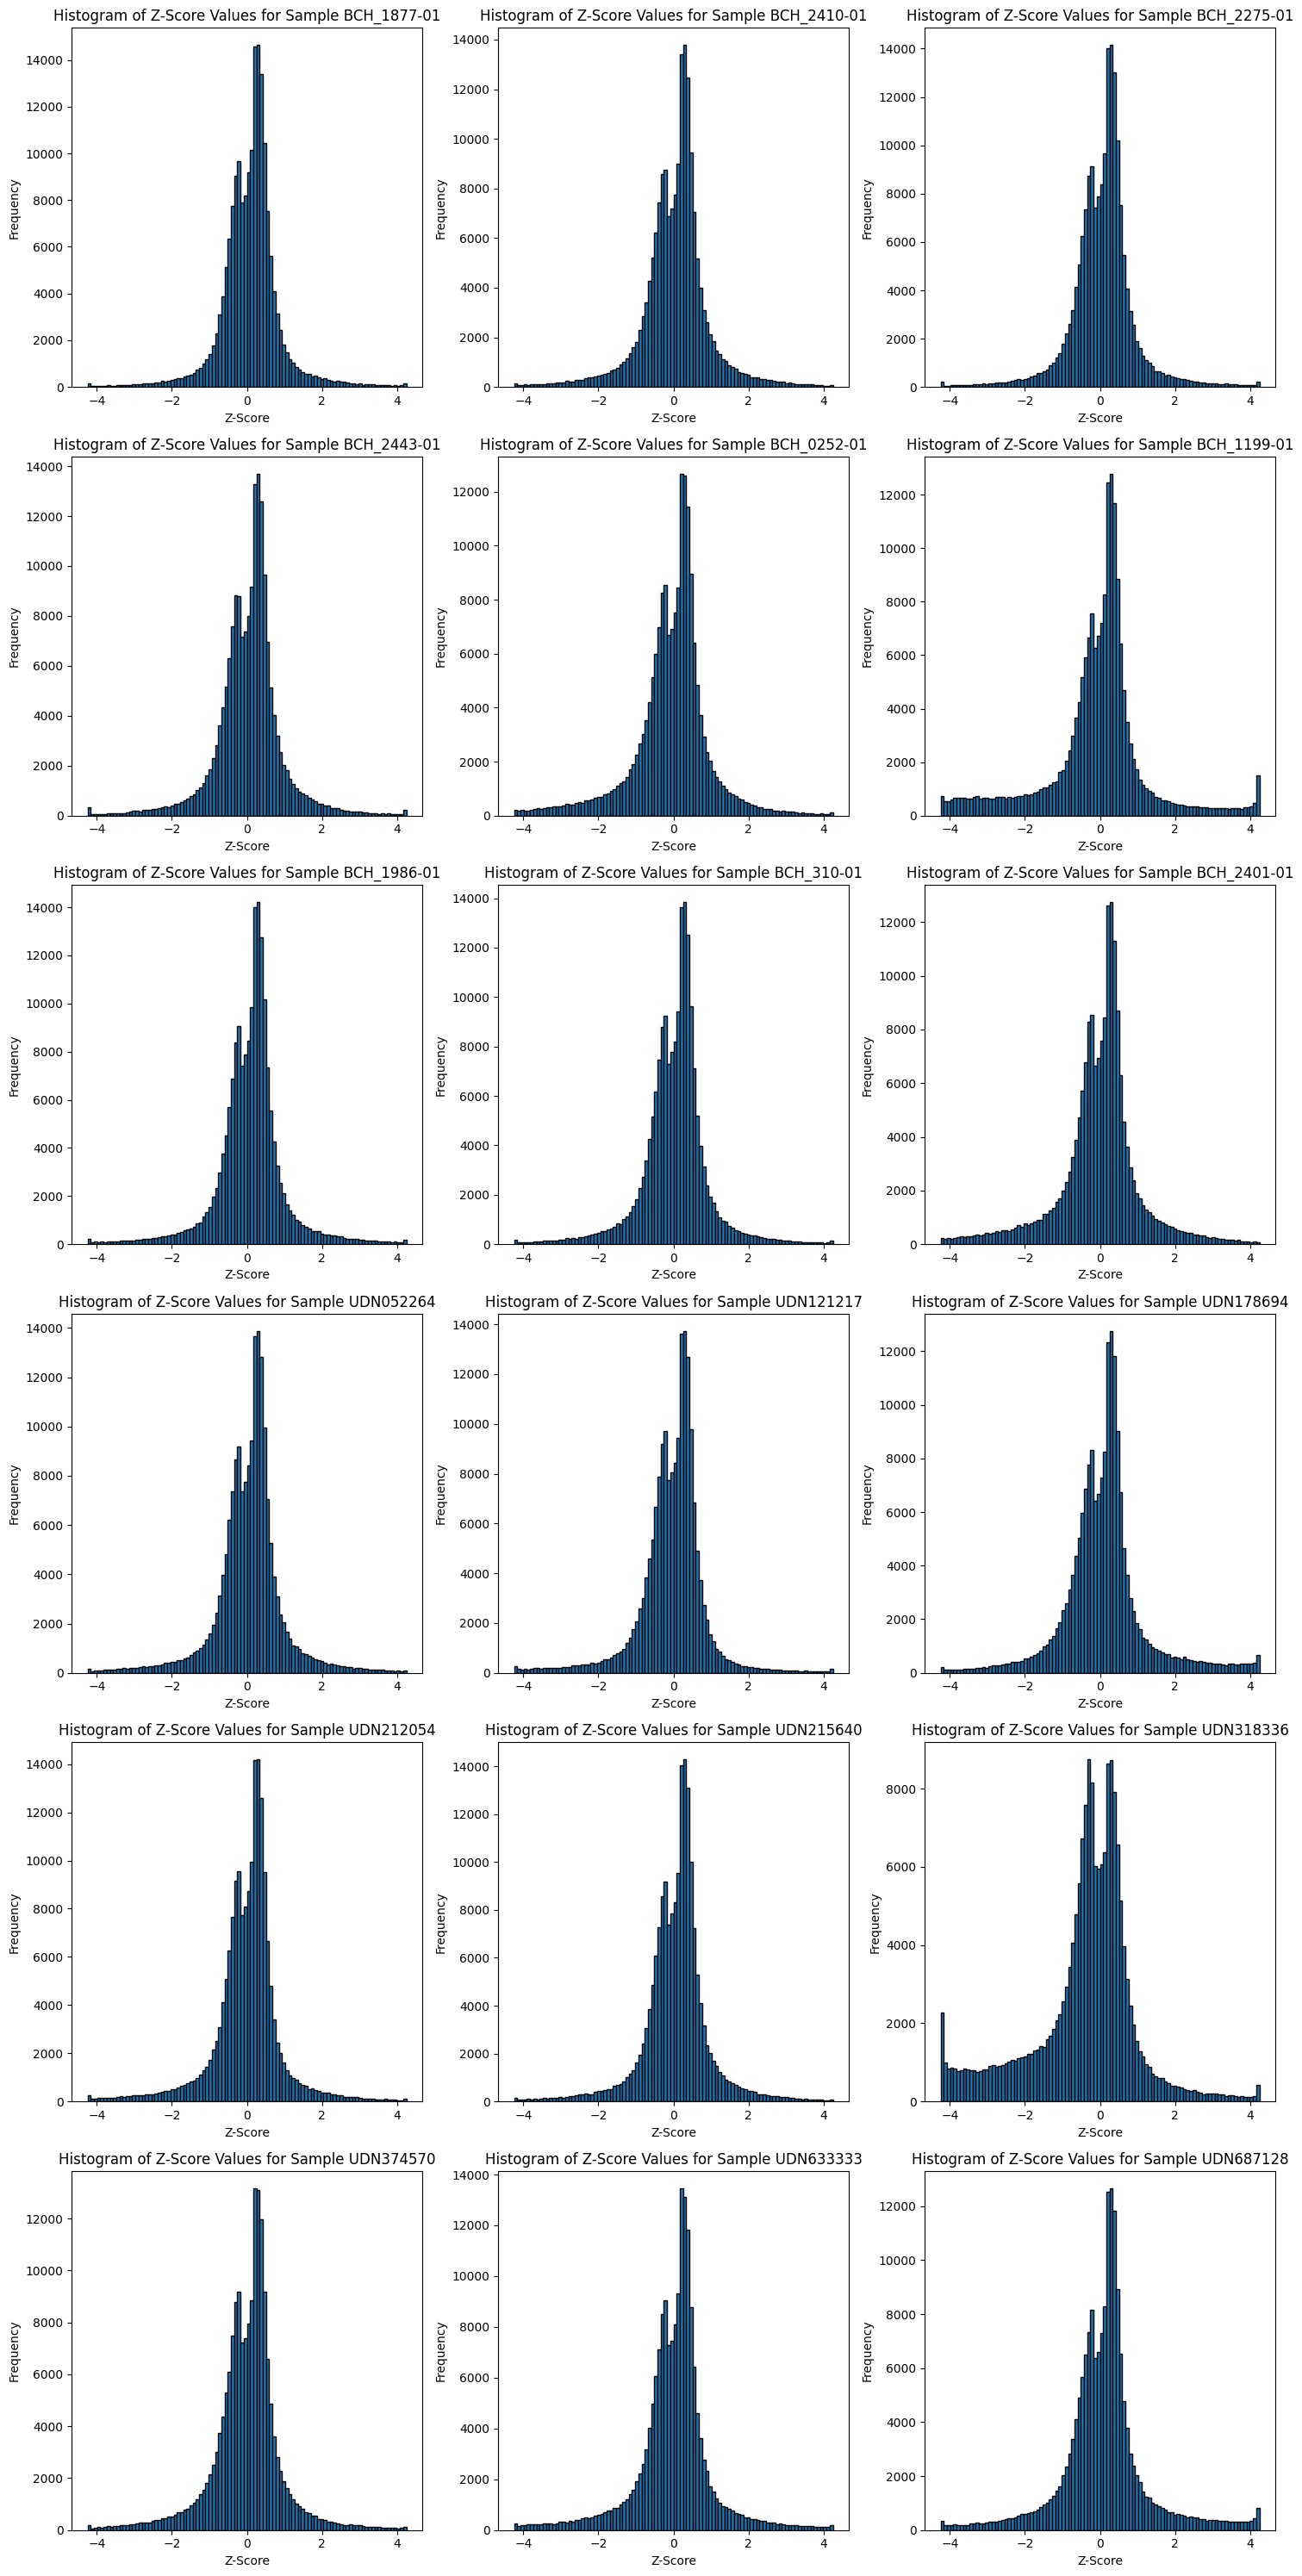

In [22]:
# Get unique samples
unique_samples = df['Sample'].unique()

# Create subplots
num_samples = len(unique_samples)
num_cols = 3
num_rows = (num_samples + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, sample in enumerate(unique_samples):
    filtered_df = df[df['Sample'] == sample]
    z_score_values = filtered_df['z_score'].dropna()
    
    # Create histogram in the appropriate subplot
    axes[i].hist(z_score_values, bins=100, edgecolor='black')
    axes[i].set_xlabel('Z-Score')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of Z-Score Values for Sample {sample}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Z-score vs test-statistic

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(0.5, 0, 'Test Statistic')

Text(0, 0.5, 'Z-Score')

Text(0.5, 1.0, 'Scatter Plot of Z-Score vs Test Statistic for Sample UDN212054')

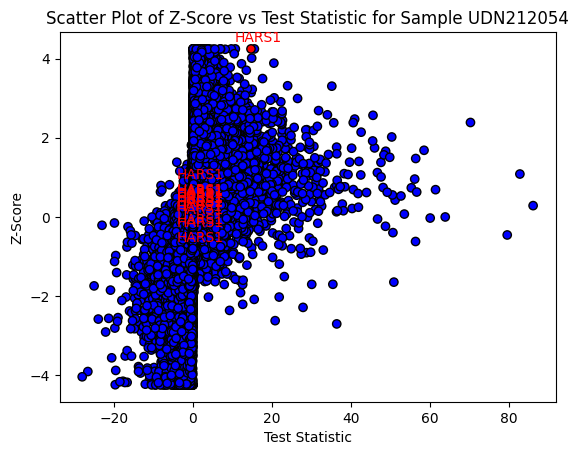

In [23]:
# Filter the DataFrame to include only rows for the sample 'UDN212054'
filtered_df = df[df['Sample'] == 'UDN212054']

# Create a scatter plot with different colors
colors = ['red' if gene == 'HARS1' else 'blue' for gene in filtered_df['associated_gene']]
plt.scatter(filtered_df['test_statistic'], filtered_df['z_score'], c=colors, edgecolor='black')

# Label points where associated_gene is 'HARS1'
for i, row in filtered_df.iterrows():
    if row['associated_gene'] == 'HARS1':
        plt.annotate('HARS1', (row['test_statistic'], row['z_score']),
                     textcoords="offset points", xytext=(5,5), ha='center', color='red')

plt.xlabel('Test Statistic')
plt.ylabel('Z-Score')
plt.title('Scatter Plot of Z-Score vs Test Statistic for Sample UDN212054')
plt.show()

## Plotting NormalizedFractionDifference against Z-score

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(0.5, 0, 'NormalizedFractionDifference')

Text(0, 0.5, 'Z-Score')

Text(0.5, 1.0, 'Scatter Plot of Z-Score vs NormalizedFractionDifference for Sample UDN212054')

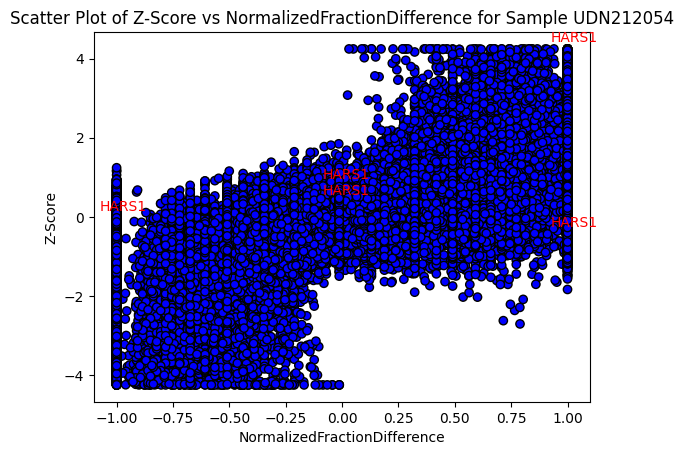

In [24]:
# Filter the DataFrame to include only rows for the sample 'UDN212054'
filtered_df = df[df['Sample'] == 'UDN212054']

# Create a scatter plot
colors = ['red' if gene == 'HARS1' else 'blue' for gene in filtered_df['associated_gene']]
plt.scatter(filtered_df['NormalizedFractionDifference'], filtered_df['z_score'], c=colors, edgecolor='black')

# Label points where associated_gene is 'HARS1'
for i, row in filtered_df.iterrows():
    if row['associated_gene'] == 'HARS1':
        plt.annotate('HARS1', (row['NormalizedFractionDifference'], row['z_score']),
                     textcoords="offset points", xytext=(5,5), ha='center', color='red')

plt.xlabel('NormalizedFractionDifference')
plt.ylabel('Z-Score')
plt.title('Scatter Plot of Z-Score vs NormalizedFractionDifference for Sample UDN212054')
plt.show()

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(5, 5, 'HARS1')

Text(0.5, 0, 'NormalizedFractionDifference')

Text(0, 0.5, 'Z-Score')

Text(0.5, 1.0, 'Scatter Plot of Z-Score vs NormalizedFractionDifference for Sample UDN212054')

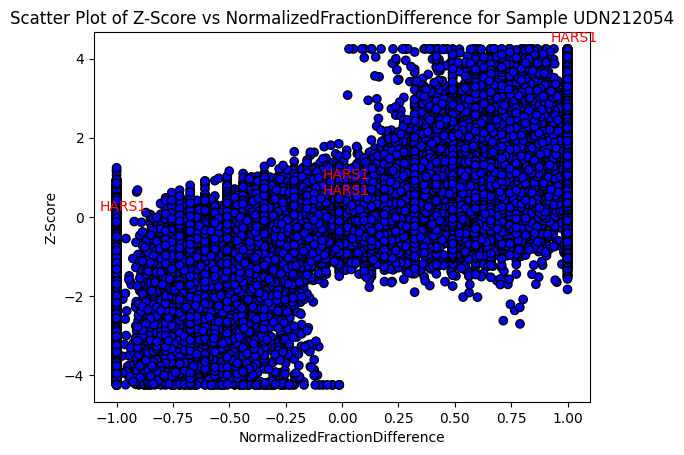

In [33]:
# If an isoform has a z-score that is >3 in any of the samples other than UDN212054, then remove the isoform:

# Identify isoforms with z-score > 3 in any samples other than UDN212054
isoforms_to_remove = df[(df['Sample'] != 'UDN212054') & (df['z_score'] > 3)]['Isoform_PBid'].unique()

# Filter out these isoforms from the DataFrame
df_filtered = df[~df['Isoform_PBid'].isin(isoforms_to_remove)]

# Filter the DataFrame to include only rows for the sample 'UDN212054'
filtered_df = df_filtered[df_filtered['Sample'] == 'UDN212054']

# Create a scatter plot
colors = ['red' if gene == 'HARS1' else 'blue' for gene in filtered_df['associated_gene']]
plt.scatter(filtered_df['NormalizedFractionDifference'], filtered_df['z_score'], c=colors, edgecolor='black')

# Label points where associated_gene is 'HARS1'
for i, row in filtered_df.iterrows():
    if row['associated_gene'] == 'HARS1':
        plt.annotate('HARS1', (row['NormalizedFractionDifference'], row['z_score']),
                     textcoords="offset points", xytext=(5,5), ha='center', color='red')

plt.xlabel('NormalizedFractionDifference')
plt.ylabel('Z-Score')
plt.title('Scatter Plot of Z-Score vs NormalizedFractionDifference for Sample UDN212054')
plt.show()

In [36]:
# Find the maximum z-score value
max_z_score = df['z_score'].max()

# Filter the DataFrame to include only rows with the maximum z-score
max_z_score_rows = df[df['z_score'] == max_z_score]

# Calculate the number of rows with the maximum z-score
num_max_z_score_rows = len(max_z_score_rows)

print(f"The number of rows with the maximum z-score is: {num_max_z_score_rows}")

The number of rows with the maximum z-score is: 10


In [37]:
max_z_score_rows

,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,...,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,ratio,absolute_diff,test_statistic,z_score,neg_log_P_Value_Hyp1
325272,PB.114523.319,UDN212054,15,6,novel_not_in_catalog,SIK2,novel,at_least_one_novel_splicesite,0.091415,NaN,...,ENSG00000170145,NaN,NaN,Sik2 (MGI:2445031),False,1.753771,1.584617,1.110291,4.242641,1.038981
328232,PB.114699.1651,BCH_2275-01,17,2,novel_not_in_catalog,RBM7,novel,at_least_one_novel_splicesite,0.000351,NaN,...,ENSG00000076053,NaN,NaN,Rbm7 (MGI:1914260),False,3.185158,2.887029,3.273649,4.242641,3.454490
374634,PB.116448.370,BCH_1877-01,10,0,incomplete-splice_match,SLC2A3,ENST00000075120.12,mono-exon,0.004758,NaN,...,ENSG00000059804,pseudogene SLC2A3P on 5q34,NaN,Slc2a3 (MGI:95757),False,2.174522,1.174522,1.255965,4.242641,2.322590
567607,PB.124868.121,UDN215640,14,6,novel_not_in_catalog,LNX2,novel,at_least_one_novel_splicesite,0.081179,NaN,...,ENSG00000139517,NaN,NaN,Lnx2 (MGI:2155959),False,1.791808,1.645813,1.181105,4.242641,1.090557
1098002,PB.149315.50,BCH_2275-01,28,23,novel_not_in_catalog,KRT10,novel,at_least_one_novel_splicesite,0.254837,NaN,...,ENSG00000186395,mutation identified in 1 IHL family,"""Ichthyosis, annular epidermolytic 1, 607602 (...",Krt10 (MGI:96685),True,1.338820,1.590349,0.578042,4.242641,0.593738
1457636,PB.162569.38,UDN318336,178,215,novel_not_in_catalog,POLR3F,novel,at_least_one_novel_splicesite,0.061544,NaN,...,ENSG00000132664,mutation identified in 1 IMD101 family,"""?Immunodeficiency 101 (varicella zoster virus...",Polr3f (MGI:1924086),True,1.185232,1.356356,0.303166,4.242641,1.210815
2401414,PB.51013.1108,UDN633333,10,0,incomplete-splice_match,SH3RF1,ENST00000284637.14,3prime_fragment,0.004494,NaN,...,ENSG00000154447,NaN,NaN,Sh3rf1 (MGI:1913066),False,3.013786,2.013786,2.533118,4.242641,2.347415
2466939,PB.55914.334,BCH_2443-01,31,8,novel_not_in_catalog,SHLD3,novel,at_least_one_novel_splicesite,0.000390,NaN,...,ENSG00000253251,NaN,NaN,Shld3 (MGI:6194609),False,2.448354,2.888585,2.530976,4.242641,3.409038
2585941,PB.60806.4253,BCH_310-01,10,8,incomplete-splice_match,SPARC,ENST00000231061.9,3prime_fragment,0.902293,NaN,...,ENSG00000113140,NaN,"""Osteogenesis imperfecta, type XVII, 616507 (3...",Sparc (MGI:98373),True,1.103732,0.235889,0.043507,4.242641,0.044652
2901154,PB.77241.10458,BCH_0252-01,82,50,full-splice_match,RABGEF1,ENST00000284957.9,alternative_3end,0.741487,NaN,...,ENSG00000154710,NaN,NaN,Rabgef1 (MGI:1929459),False,1.071753,0.891799,0.091950,4.242641,0.129897


In [38]:
# If I use the z-scores to rank, with the max z-score getting a rank of 1. What is the rank of the z-score 
# for isoform_pbid PB.60131.293 in Sample UDN212054

# Filter the DataFrame to include only rows for the sample 'UDN212054'
filtered_df = df[df['Sample'] == 'UDN212054']

# Sort the filtered DataFrame by the z_score in descending order
sorted_df = filtered_df.sort_values(by='z_score', ascending=False)

# Reset the index to create a ranking
sorted_df = sorted_df.reset_index(drop=True)

# Determine the rank of 'PB.60131.293'
isoform_rank = sorted_df[sorted_df['Isoform_PBid'] == 'PB.60131.293'].index[0] + 1  # Adding 1 to convert zero-based index to rank

print(f"The rank of the z-score for isoform PB.60131.293 in sample UDN212054 is: {isoform_rank}")

The rank of the z-score for isoform PB.60131.293 in sample UDN212054 is: 40


In [39]:
len(filtered_df)

186466

## Rank of positive control

In [18]:
# Filter the DataFrame to include only rows for the sample 'UDN212054'
sample_df = df[df['Sample'] == 'UDN212054']

sample_df = sample_df[sample_df['NormalizedFractionDifference'] > 0]

# Calculate the 99.5th percentile of the z-scores within this sample
percentile_995 = np.percentile(sample_df['z_score'], 99.5)

# Filter the DataFrame to include only rows with z-scores above this percentile within the sample
top_percentile_df = sample_df[sample_df['z_score'] > percentile_995]

# Sort the filtered DataFrame by the test statistic in descending order
sorted_df = top_percentile_df.sort_values(by='test_statistic', ascending=False)

# Reset the index to create a ranking
sorted_df = sorted_df.reset_index(drop=True)

# Determine the rank of 'HARS1' in the sorted DataFrame
hars1_rank = sorted_df[sorted_df['Isoform_PBid'] == 'PB.60131.293'].index[0] + 1  # Adding 1 to convert zero-based index to rank

print(f"The rank of HARS1 in terms of test statistic among the top 0.5 percentile of z-scores in UDN212054 is: {hars1_rank}")

The rank of HARS1 in terms of test statistic among the top 0.5 percentile of z-scores in UDN212054 is: 3


In [19]:
# Define the percentiles to check
percentiles = [99.9, 99.5, 99, 98, 95, 90, 80, 50]

# Filter the DataFrame to include only rows for the sample 'UDN212054'
sample_df = df[df['Sample'] == 'UDN212054']
sample_df = sample_df[sample_df['NormalizedFractionDifference'] > 0]


# Loop through each percentile, calculate and print the rank
for percentile in percentiles:
    # Calculate the percentile of the z-scores within this sample
    percentile_value = np.percentile(sample_df['z_score'], percentile)

    
    # Filter the DataFrame to include only rows with z-scores above this percentile within the sample
    top_percentile_df = sample_df[sample_df['z_score'] > percentile_value]
    
    # Sort the filtered DataFrame by the test statistic in descending order
    sorted_df = top_percentile_df.sort_values(by='test_statistic', ascending=False)
    
    # Reset the index to create a ranking
    sorted_df = sorted_df.reset_index(drop=True)
    
    try:
        # Determine the rank of 'HARS1' in the sorted DataFrame
        hars1_rank = sorted_df[sorted_df['Isoform_PBid'] == 'PB.60131.293'].index[0] + 1  # Adding 1 to convert zero-based index to rank
        print(f"The rank of HARS1 in terms of test statistic among the top {percentile} percentile of z-scores in UDN212054 is: {hars1_rank}")
    except IndexError:
        print(f"HARS1 is not in the top {percentile} percentile of z-scores in UDN212054.")

The rank of HARS1 in terms of test statistic among the top 99.9 percentile of z-scores in UDN212054 is: 2
The rank of HARS1 in terms of test statistic among the top 99.5 percentile of z-scores in UDN212054 is: 3
The rank of HARS1 in terms of test statistic among the top 99 percentile of z-scores in UDN212054 is: 4
The rank of HARS1 in terms of test statistic among the top 98 percentile of z-scores in UDN212054 is: 8
The rank of HARS1 in terms of test statistic among the top 95 percentile of z-scores in UDN212054 is: 33
The rank of HARS1 in terms of test statistic among the top 90 percentile of z-scores in UDN212054 is: 91
The rank of HARS1 in terms of test statistic among the top 80 percentile of z-scores in UDN212054 is: 199
The rank of HARS1 in terms of test statistic among the top 50 percentile of z-scores in UDN212054 is: 341


In [13]:
sorted_df.head(10)

,Isoform_PBid,Sample,cyclo_count,noncyclo_count,structural_category,associated_gene,associated_transcript,subcategory,P_Value_Hyp1,Max_P_Value_Hyp2_below_median,...,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID,PhenotypesNotEmpty,ratio,absolute_diff,test_statistic,z_score,neg_log_P_Value_Hyp1
0,PB.148086.309,UDN212054,157,11,novel_not_in_catalog,FAM83G,novel,intron_retention,2.926557e-28,NaN,...,ENSG00000188522,NaN,NaN,Fam83g (MGI:1916890),False,9.640692,26.101781,15.562123,4.242641,27.533643
1,PB.54616.115,UDN212054,111,5,novel_not_in_catalog,GDNF,novel,intron_retention,7.002410e-22,NaN,...,ENSG00000168621,NaN,"""{Hirschsprung disease, susceptibility to, 3},...",Gdnf (MGI:107430),True,10.884733,18.964297,14.876854,4.010379,21.154752
2,PB.60131.293,UDN212054,74,0,novel_in_catalog,HARS1,novel,combination_of_known_splicesites,5.381919e-17,NaN,...,ENSG00000170445,NaN,"""Charcot-Marie-Tooth disease, axonal, type 2W,...",Hars1 (MGI:108087),True,14.255228,13.255228,14.695103,4.242641,16.269063
3,PB.12722.414,UDN212054,131,19,novel_not_in_catalog,CAPN2,novel,at_least_one_novel_splicesite,5.148346e-19,NaN,...,ENSG00000162909,NaN,NaN,Capn2 (MGI:88264),False,5.448282,19.974868,10.738510,4.242641,18.288332
4,PB.62642.4235,UDN212054,47,0,novel_not_in_catalog,ADAMTS2,novel,at_least_one_novel_splicesite,3.503470e-11,NaN,...,ENSG00000087116,NaN,"""Ehlers-Danlos syndrome, dermatosparaxis type,...",Adamts2 (MGI:1347356),True,9.418861,8.418861,10.468801,4.120837,10.455502
5,PB.169981.66,UDN212054,1674,661,novel_not_in_catalog,CDC42EP1,novel,at_least_one_novel_splicesite,6.716693e-92,NaN,...,ENSG00000128283,NaN,NaN,Cdc42ep1 (MGI:1929763),False,2.457330,178.423200,9.711615,4.242641,91.172844
6,PB.54616.175,UDN212054,43,2,novel_not_in_catalog,GDNF,novel,intron_retention,4.138724e-09,NaN,...,ENSG00000168621,NaN,"""{Hirschsprung disease, susceptibility to, 3},...",Gdnf (MGI:107430),True,6.364085,7.334944,8.167847,4.233421,8.383134
7,PB.81640.1243,UDN212054,41,2,incomplete-splice_match,CALD1,ENST00000482470.5,5prime_fragment,1.113012e-08,NaN,...,ENSG00000122786,NaN,NaN,Cald1 (MGI:88250),False,6.102095,6.976695,7.816932,3.896709,7.953500
8,PB.54616.405,UDN212054,33,1,novel_not_in_catalog,GDNF,novel,intron_retention,1.578185e-07,NaN,...,ENSG00000168621,NaN,"""{Hirschsprung disease, susceptibility to, 3},...",Gdnf (MGI:107430),True,5.838526,5.727406,7.000540,4.242414,6.801842
9,PB.60806.5021,UDN212054,29,0,novel_not_in_catalog,SPARC,novel,at_least_one_novel_splicesite,2.869321e-07,NaN,...,ENSG00000113140,NaN,"""Osteogenesis imperfecta, type XVII, 616507 (3...",Sparc (MGI:98373),True,6.194616,5.194616,6.922240,4.242641,6.542221


In [51]:
percentile_995

np.float64(3.239432312052795)

In [15]:
percentile_995

np.float64(3.8848500524602656)

In [17]:
len(top_percentile_df)

262

## Volcano plot replacement

<Figure size 1000x600 with 0 Axes>

Text(0, 10, 'HARS1')

Text(0.5, 0, 'NormalizedFractionDifference')

Text(0, 0.5, 'Test Statistic')

Text(0.5, 1.0, 'NormalizedFractionDifference vs Test Statistic for Top 1% Isoforms in UDN212054 based on z-score')

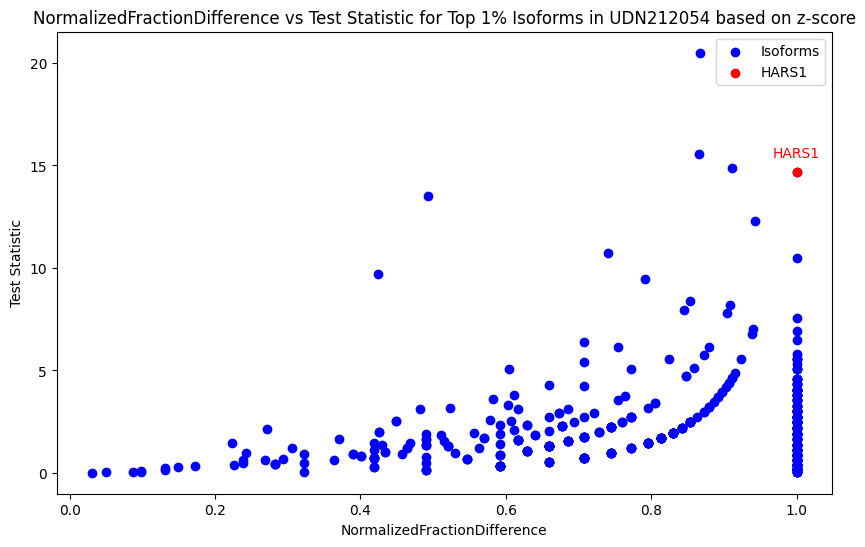

In [12]:
## For the top 5% of isoforms in UDN212054 based on z-score, plot the NormalizedFractionDifference vs test_statistic. 
# Label and color red the HARS1 isoforms.
# Filter the DataFrame to include only rows for the sample 'UDN212054'
sample_df = df[df['Sample'] == 'UDN212054']
sample_df = sample_df[sample_df['NormalizedFractionDifference'] > 0]

# Calculate the 95th percentile of the z-scores within this sample
percentile_95 = np.percentile(sample_df['z_score'], 99)

# Filter the DataFrame to include only the top 5% isoforms based on z_score
top_5_percent_df = sample_df[sample_df['z_score'] > percentile_95]

# Plot NormalizedFractionDifference vs test_statistic
plt.figure(figsize=(10, 6))
plt.scatter(top_5_percent_df['NormalizedFractionDifference'], top_5_percent_df['test_statistic'], color='blue', label='Isoforms')

# Highlight and label HARS1 isoforms
for i, row in top_5_percent_df.iterrows():
    if row['associated_gene'] == 'HARS1':
        plt.scatter(row['NormalizedFractionDifference'], row['test_statistic'], color='red', label='HARS1')
        plt.annotate('HARS1', (row['NormalizedFractionDifference'], row['test_statistic']),
                     textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.xlabel('NormalizedFractionDifference')
plt.ylabel('Test Statistic')
plt.title('NormalizedFractionDifference vs Test Statistic for Top 1% Isoforms in UDN212054 based on z-score')
plt.legend(loc='best')
plt.show()

In [ ]:
# Delete all variables
%reset -f

# Additional cleanup if needed
import gc
gc.collect()